<a href="https://colab.research.google.com/github/SeongwonTak/TIL_swtak/blob/master/RANSAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RANSAC 알고리즘

회귀분석에서 이상치가 차지하는 영향에 대한 확인과 함께, RANSAC 알고리즘에 대해 공부해보고자 한다.

## RANSAC이란?
선형 회귀에서 이상치는 크게 영향을 주게 된다. 이상치를 제거하기 위해서는 해당분야에 대한 베이스 지식과, 통계적 식견 또한 필요하다.

이상치를 제거하는 방식 대신 RANSAC(RANdom SAmple Consensus) 알고리즘에서는 안정된 회귀 모델을 보여주는데, 이는 정상치라는 일부 데이터로 회귀 모델을 훈련한다. 이는 다음의 순서대로 행동하게 된다.

1. 랜덤하게 일부 샘플을 훈련하여 모델을 훈련한다.
2. 훈련된 모델에서 다른 모든 포인트를 테스트한다.
3. 사용자가 입력한 허용 오차 안에 속한 모든 포인트는 정상치가 된다.
4. 모든 정상치를 사용하여 다시 모델을 훈련한다.
5. 모델과 정상치간의 오차를 추정한다.
6. 성능이 사용자가 정한 임계값이 도달하거나, 지정된 반복 회수에 도달하면 종료

In [3]:
# 기본코드
from sklearn.linear_model import LinearRegression, RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),
                         max_trials = 100,
                         min_samples = 50,
                         loss = 'absolute_loss',
                         residual_threshold = 5.0,
                         random_state = 0)

각 변수들에 대한 의미를 확인해보자.
- max_trials : Maximum num of iters.  defalut = 100
- min_samples : Min number of samples chosen randomly from original data.
- loss : absolute loss or squared loss.  default = absolute loss.
- residual_threshold : Maximum residual for a data sample to be classifed as an inliner. defauld = MAD(median absolute deviation) of y

## 예시
scikit-learn에 나온 공식 예제를 통해 실제 사용법을 확인해보자.
가상의 데이터를 만들어서 진행하고자 한다.

Estimated coefficients (true, linear regression, RANSAC):
82.1903908407869 [54.07798986] [82.93978165]


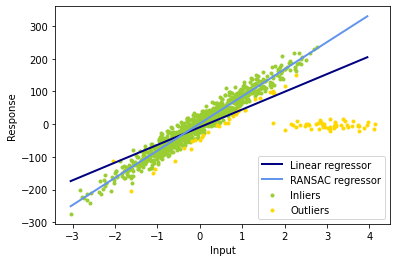

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model, datasets

n_samples = 1000
n_outliers = 50

X, y, coef = datasets.make_regression(n_samples = n_samples, n_features = 1,
                                      n_informative = 1, noise = 20,
                                      coef = True, random_state = 0)

# Add outlier data
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# Fit line using all data
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(coef, lr.coef_, ransac.estimator_.coef_)

lw = 2
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw,
         label='RANSAC regressor')
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

상단의 그래프를 확인해 보면, Linear regression의 결과는 Outlier들, 특히 우측에 몰린 부분에 영향을 받아 직선이 Inliers들을 따라가지 못하고 있음을 알 수 있다.

그러나, RANSAC에서는 비교적 이를 잘 예측하고 있음을 알 수 있다.

## RANSAC vs  Least Sqare Approximation

최소자승법의 경우는 MSE가 최소화가 되도록 데이터를 선택하나, RANSAC의 경우는 가장 많은 수의 데이터를 받는 모델의 지지를 따라간다.